# A/B Testing and Power Analysis



We going to A/B test the new landing page of a webside. I got data from https://www.kaggle.com/datasets/zhangluyuan/ab-testing.

The test metric is Conversion Rate (CR):
$$
    CR = converted / (converted + notconverted)
$$

Hypothesis: Changing landing page will increase the CR of the web.


In [1]:
import seaborn as sns
sns.set()

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np 

In [2]:
data = pd.read_csv("../data/ab_data.csv", parse_dates=["timestamp"])

In [3]:
data.head()

,user_id,timestamp,group,landing_page,converted
0,851104,2017-01-21 22:11:48.556739,control,old_page,0
1,804228,2017-01-12 08:01:45.159739,control,old_page,0
2,661590,2017-01-11 16:55:06.154213,treatment,new_page,0
3,853541,2017-01-08 18:28:03.143765,treatment,new_page,0
4,864975,2017-01-21 01:52:26.210827,control,old_page,1


In [4]:
data.shape

(294478, 5)

In [5]:
multipletime_user = data["user_id"].value_counts()[data["user_id"].value_counts() > 1].index
data = data[~data["user_id"].isin(multipletime_user)]

In [6]:
data.shape

(286690, 5)

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 286690 entries, 0 to 294477
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   user_id       286690 non-null  int64         
 1   timestamp     286690 non-null  datetime64[ns]
 2   group         286690 non-null  object        
 3   landing_page  286690 non-null  object        
 4   converted     286690 non-null  int64         
dtypes: datetime64[ns](1), int64(2), object(2)
memory usage: 13.1+ MB


In [8]:
data["group"].value_counts()

treatment    143397
control      143293
Name: group, dtype: int64

In [9]:
# the control group see old_page and the treatment group see the new_page
pd.crosstab(data['group'], data['landing_page'])

landing_page,new_page,old_page
group,,
control,0,143293
treatment,143397,0


## Designing the A/B test in 3 steps
1. setup statistical hypothesis
2. find the minimum (reliably) detectable effect or MDE size & determine the test durartion 
3. calculate the appropriate sample size

### 1. Setup Statistical Hypothesis
$$
    H_0 : \mu_c = \mu_t \\
    H_1 : \mu_c \neq \mu_t
$$

$\mu_c$ is sampling distribution mean of CR in control group  
$\mu_t$  is sampling distribution mean of CR in treatment group  

We test at 0.05 significant level ($\alpha = 0.05$)

### 2. Find the minimum (reliably) detectable effect or MDE size & determine the test duration 
The MDE affects the appropriate sample size for running an A/B test. The lower MDE, the larger sample size are required to correctly reject the Null Hypothesis at an certain probability. Too large MDE can leads to wasted test. For example, we set MDE at 50% of increasing conversion rate. In this case, it's like we running an unlogical test and the test unlikely to deriver any significant result, and of couse we wasted our time and money. In contrast, we set too low MDE. The test will required more sample size to correctly reject the Null Hypothesis at an certain probability. This means that we have to run our test longer and spend more money and time. The appropriate MDE should be set in the businessman sight. Basically, it shoud be the smallest effect that make your business breakeven if you implement the change that is being tested. 

In this notebook, let's say we are runing the test within a week.

In [10]:
old_data = data[(data["timestamp"] >= "2017-01-02") & 
               (data["timestamp"] < "2017-01-10") &
               (data["group"] == "control")] # assume it is the info before new landning page

A_data = data[(data["timestamp"] >= "2017-01-10") & 
               (data["timestamp"] < "2017-01-18") &
               (data["group"] == "control")] # running the test in next week 

B_data = data[(data["timestamp"] >= "2017-01-10") & 
               (data["timestamp"] < "2017-01-18") &
               (data["group"] == "treatment")] # running the test in next week 

In [11]:
cr_old = old_data["converted"].sum() / old_data["converted"].shape[0]
print(cr_old)

0.11920694441567051


In [12]:
# set various MDE 
MDE_small = 0.01 # 1%
MDE_medium = 0.10 # 10%
MDE_large = 0.20 # 20%

In [13]:
cr_old * (1 + MDE_small)

0.12039901385982721

In [14]:
cr_old * (1 + MDE_medium)

0.13112763885723758

In [15]:
cr_old * (1 + MDE_large)

0.1430483332988046

Let's say the business would like to see an increase in CR of at least 10% in order to implement the new landing page. So, we pick MDE at 0.1

### 3. Calculate the appropriate sample size
This could be done using a Power Analysis. The appropriate sample size depends on 
- MDE as mention above
- alpha, the significance level, e.g. 0.05, is the probability of a type I error, that is wrong rejections if the Null Hypothesis is true
- power, the power of the test, e.g. 0.8, is one minus the probability of a type II error. Power is the probability that the test correctly rejects the Null Hypothesis if the Alternative Hypothesis is true

We will deep down into the details of Power Analysis later, but now we will use NormalIndPower.solve_power function from statsmodels.stats.api to easily solve the appropriate sample size.

In [16]:
import statsmodels.stats.api as sms
effect_size = sms.proportion_effectsize(cr_old, cr_old * (1 + MDE_medium))

required_n = sms.NormalIndPower().solve_power(
    effect_size=effect_size,
    power=0.8, # we would like to correctly reject the H0 with 80% probability
    alpha=0.05, # we ok with 5% of type I error
)

print(required_n)

12089.86383585548


In real work this means we have to run the test until we got 12090 samples of each group. So, I will just random pick the 12090 from A and B

In [17]:
control_data = A_data.reset_index(drop=True).sample(round(required_n), random_state=42)


In [18]:
treatment_data = B_data.reset_index(drop=True).sample(round(required_n), random_state=42)

In [19]:
ab_data = pd.concat([control_data, treatment_data], axis=0)

## Run A/B Testing

We run the test using proportions_ztest from statsmodels and we will reject H0 if p-value less than 0.05

In [20]:
import scipy.stats as stats

# calculate the necessary stats of each group

se = lambda x: stats.sem(x, ddof=0) # calculate standard error

# calculate convertion stats 
converted = ab_data.groupby("group")["converted"].agg(["count", np.sum, np.mean, np.std, se])
converted.columns = ["nobs", "total_converted", "conversion_rate", "standard_deviation", "standard_error"]
converted

,nobs,total_converted,conversion_rate,standard_deviation,standard_error
group,,,,,
control,12090,1385,0.114557,0.318500,0.002897
treatment,12090,1433,0.118528,0.323245,0.002940


In [21]:
from statsmodels.stats.proportion import proportions_ztest, proportion_confint

# use 2 sample z-test for hypothesis testing
successes = [converted["total_converted"]["control"], converted["total_converted"]["treatment"]]
nobs = [converted["nobs"]["control"], converted["nobs"]["treatment"]]

z_stat, pval = proportions_ztest(successes, nobs=nobs)

print(f"z-stat is {z_stat}, p-value is {pval}")

z-stat is -0.9620063436938238, p-value is 0.3360464173664066


The p-value of 0.336 (> 0.05) suggests that we can not reject H0. Although we found a little bit higher of conversion rate of treatment group but it is no significantly different from the control group.  

In [22]:
(lower_con, lower_treat), (upper_con, upper_treat) = proportion_confint(successes, nobs=nobs, alpha=0.05)

print(f"confidence interval of control group is [{lower_con}, {upper_con}]")
print(f"confidence interval of treatment group is [{lower_treat}, {upper_treat}]")

confidence interval of control group is [0.10888038136811548, 0.12023458968233944]
confidence interval of treatment group is [0.11276602774067992, 0.12428938995989908]


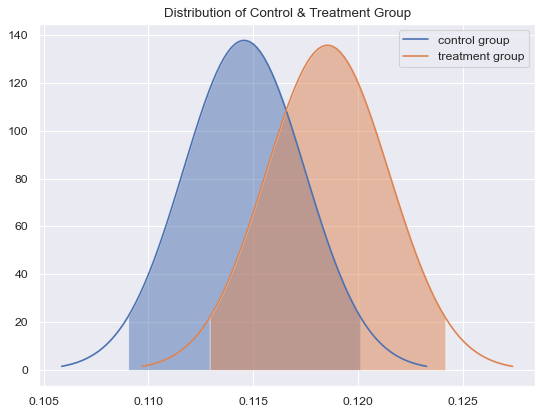

In [23]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

plt.figure(figsize=(8, 6), dpi=80)

mu_c = converted["conversion_rate"]["control"]
sigma_c = converted["standard_error"]["control"]
x = np.linspace(mu_c - 3*sigma_c, mu_c + 3*sigma_c, 100)
pdf_c = stats.norm.pdf(x, mu_c, sigma_c)
plt.plot(x, pdf_c, label="control group")
plt.fill_between(x, pdf_c, where=(lower_con < x) & (x < upper_con), alpha=0.5)

mu_t = converted["conversion_rate"]["treatment"]
sigma_t = converted["standard_error"]["treatment"]
x = np.linspace(mu_t - 3*sigma_t, mu_t + 3*sigma_t, 100)
pdf_t = stats.norm.pdf(x, mu_t, sigma_t)
plt.plot(x, pdf_t, label="treatment group")
plt.fill_between(x, pdf_t, where=(lower_treat < x) & (x < upper_treat), alpha=0.5)

plt.title('Distribution of Control & Treatment Group')
plt.legend()
plt.show()

This figure shows that they have an overlaped CI. So, we can not say that they come from a different distribution. 

## Conclusion 
According to the A/B testing, we can not say that the new landing page significantly increase the CR of the web, at 95% confidence interval. In this test, we setup experiment using 3 steps. First, we define statistical hypothesis to check that the CR different between control and test group. Second, we determine the MDE by assume that business would like to see 10% increase of CR. Third, we calculate the appropriate sample size, using Power Analysis, and found that we need 12090 samples to have 80% chance of correctly reject H0. Lastly, we run the test using z-test. We got p-value of 0.336 which is much larger than 0.05 of alpha, so we can not reject H0 and conclude that there is no different in the results between old and new landing page. 

Next part, we will explore more about the Power Analysis

# Power Analysis
To understand the Power Analysis, we have to familiar with some terminology. 
- Null Hypothesis
- Alternate Hypothesis
- TypeI error & TypeII error
- Alpha, Beta & Power

**Null Hypothesis**: A null hypothesis is a type of statistical hypothesis that proposes that no statistical significance exists in a set of given observations. The word "null" comes from nullify. It’s a commonly accepted fact that researchers work to nullify, if the null hypothesis can not be rejected.

**Alternative Hypothesis**: The alternate hypothesis is just an alternative to the null. If we can reject the null hypothesis, we accept the alternate hypothesis.

**TypeI error & TypeII error**:
In a statistical hypothesis testing, there is 2 ways that cause an error. First, we reject the null hypothesis while it's acually true. This is also called TypeI error. Secound, we don't reject the null hypothesis while it's acually false. This is also called TypeII error.

<p align="center">
    <img src="../type12error.png">
</p>

**Alpha, Beta & Power**: In statistic, we can not be so sure that the conclusion we've made is 100% true. But, we make the conclusion under an acceptable chance of error. The acceptable chance of TypeI error is alpha. If we set alpha of 0.05, it means we accept 5% probabilty of TypeI error. Likewise, beta is the acceptable chance of TypeII error. So, the beta of 0.20 means we accept 20% probabilty of TypeII error. The power is equal 1 - beta. This is the probabilty that we correctly reject the null hypothesis. For example, we set beta of 0.2, the power will be 1 - 0.2 = 0.8. In this case, if we don't reject the H0, there is 20% chance that we don't reject while it false (TypeII). On the other hand, if we reject H0, there is at lease 80% chance that we correctly reject H0. Let's see some visualization below.

In [24]:
def null_alter_dist_plot(mu_0=0, mu_1=3, sigma_0=1, sigma_1=1, alpha=0.5):
    c = stats.norm.ppf(1 - alpha)
    plt.figure(figsize=(8, 6), dpi=80)

    x_0 = np.linspace(mu_0 - 3*sigma_0, mu_0 + 3*sigma_0, 100)
    pdf_0 = stats.norm.pdf(x_0, mu_0, sigma_0)
    plt.plot(x_0, pdf_0, label="Null Hypothesis")

    x_1 = np.linspace(mu_1 - 3*sigma_1, mu_1 + 3*sigma_1, 100)
    pdf_1 = stats.norm.pdf(x_1, mu_1, sigma_1)
    plt.plot(x_1, pdf_1, label="Alternative Hypothesis")


    plt.fill_between(x_1, pdf_1, where= x_1 <= c, label='beta', alpha=0.5)
    plt.fill_between(x_1, pdf_1, where= x_1 >= c, label='power', alpha=0.5)
    plt.fill_between(x_0, pdf_0, where= x_0 >= c, label='alpha', alpha=0.5)

    plt.vlines(x=c, ymin=0, ymax=0.4 ,color='r', linestyle='-')

    plt.title('Null & Alternative Hypothesis')
    plt.legend()
    plt.show()

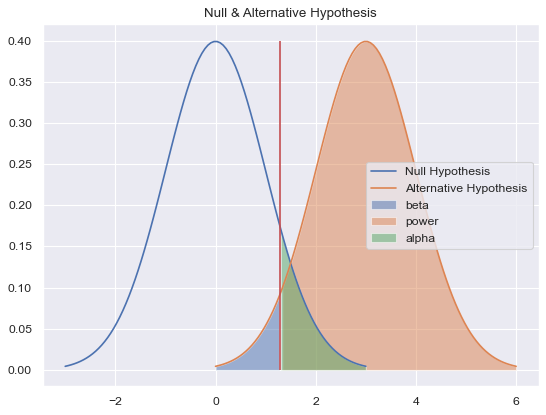

In [25]:
mu_0 = 0
sigma_0 = 1
mu_1 = 3
sigma_1 = 1
alpha = 0.1

null_alter_dist_plot(mu_0=mu_0, mu_1=mu_1, sigma_0=sigma_0, sigma_1=sigma_1, alpha=alpha)

The figure above shows that power is the area under alternative hyothesis that is not in the beta area. 

According to the Central Limit Theorem as the sample size increases, the standard error decrease. 

$$ \sigma_{\overline X} = \sqrt{\frac{\sigma^2}{n}}.$$

Let's see what happend if the standard error decrease. 

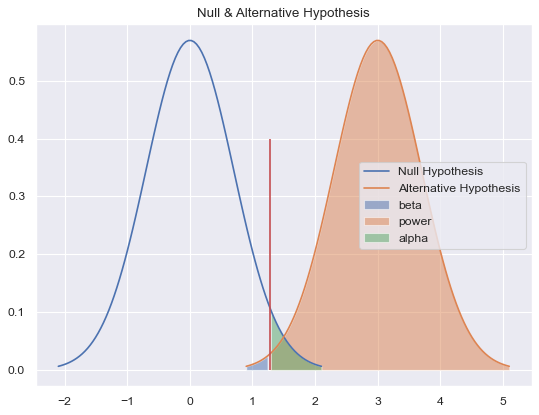

In [26]:
mu_0 = 0
sigma_0 = 0.7
mu_1 = 3
sigma_1 = 0.7
alpha = 0.1

null_alter_dist_plot(mu_0=mu_0, mu_1=mu_1, sigma_0=sigma_0, sigma_1=sigma_1, alpha=alpha)

As the number of sample increases and SE decreases, the critical area (alpha & beta) is getting smaller. So, we will have more confidence to reject the H0.

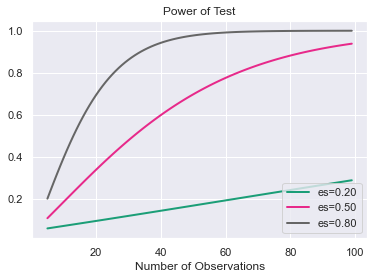

In [27]:
# parameters for power analysis
effect_sizes = np.array([0.2, 0.5, 0.8])
sample_sizes = np.array(range(5, 100))

# calculate power curves from multiple power analyses
analysis = sms.TTestIndPower()
analysis.plot_power(dep_var='nobs', nobs=sample_sizes, effect_size=effect_sizes)
plt.show()

This plot shows that at a fixed effect_sizes, as number of observations increase, the power of the test increase, and the smaller effect size, the larger sample size required in order to give the same power. 